In [250]:
import os,sys
import pandas as pd
import numpy as np

from multiprocessing import Pool
from functools import partial

import h5py as h5

import plotly.graph_objects as go
import plotly.express as px

from multiprocessing import Pool
from functools import partial

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', -1)


#sensor_data = '/users/staff/federico/GitHub/CEUAS_master_SEPTEMBER2021/CEUAS/CEUAS/public/merge/utilities/sensor_tables/ALL'
merged = '/scratch/das/federico/MERGED_25FEB2022'
#files = [f for f in  os.listdir(sensor_data) if 'all' not in f ]

#sensor_configuration = 'sensor_configuration_all.csv'

#files_n = ['Lindenberg' , 'Payerne', 'Alaska']
#files = ['0-20001-0-10393_CEUAS_merged_v1.nc' , '0-20000-0-06610_CEUAS_merged_v1.nc' , '0-20000-0-70219_CEUAS_merged_v1.nc']

#lin = merged + '/' + files[0]

sensor_data = '/users/staff/federico/GitHub/CEUAS_master_SEPTEMBER2021/CEUAS/CEUAS/public/merge/utilities/sensor_tables/ALL'
sensor_conf = pd.read_csv( sensor_data +  '/sensor_configuration_all.csv', sep='\t',  index_col=0)


# add a converted column (to sctrings)
sensor_id_s = []
for s in sensor_conf.sensor_id.values:
    try:
        s = eval(s).decode('utf-8').replace(' ','')
    except:
        pass
    s = str(s)
    sensor_id_s.append(s)

sensor_conf['sensor_id_s'] = sensor_id_s




<ipython-input-250-73753bf5a04e>:18: FutureWarning:

Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.



In [251]:
# Function to locate and extract comments for a sensor_id out of the sensor_configuration table

def get_sensor_id_comments(sensor_id, sensor_conf):
    """ Extracts the sensor ids from the reduced sensor summary tables, 
    and retrieves the description from the sensor_configuration table """

    s = sensor_id

    # list placeholders
    sensors, description  = [], []

    d = sensor_conf[sensor_conf['sensor_id_s'] == s ]
    if d.empty:
        s = s.replace('.0', '').replace('.', '')
        if len(s) == 2 and int(s) != 80:
            s = '1' + s
        elif len(s) ==2 and int(s)==80:
            s = '80'
        d = sensor_conf[sensor_conf['sensor_id'] == s ]

    try:
        com = d.comments.values[0]
    except:
        com = 'NA'        

    try:
        com = eval(com).decode('utf-8')
    except:
        pass

    return com




In [252]:
get_sensor_id_comments('VDT', sensor_conf)

'  VDT Vaisala RS80 PC Cora auto corr, ranging wind 31313=46203^ <F=T403FL or 1680AL,P=Ac,T=CB,U=A,W=Ta>'

## Analyze Lindenberg

In [393]:
file = '/scratch/das/federico/MERGED_25FEB2022/0-20001-0-10393_CEUAS_merged_v1.nc'
f = h5.File(file, 'r')
ts = f['recordtimestamp'][:]
tsd = pd.to_datetime( ts, unit='s',  origin=pd.Timestamp('1900-01-01') )

index_minus = np.where(tsd <=  pd.Timestamp('1994-01-01')  )[0][-1]
index_plus = np.where(tsd >  pd.Timestamp('1997-01-01')  )[0][0]
index_plus_ext = np.where(tsd >  pd.Timestamp('2013-01-31')  )[0][0]

ind_obs = list(f['recordindex'][:]) [index_minus:index_plus]

ind_obs_ext = list(f['recordindex'][:]) [index_minus:index_plus_ext]

f.close()

In [254]:
i = np.take( f['observations_table']['sensor_id'][:].view('|S4') , ind_obs) 
ids_s = [s.decode('utf-8') for s in i ]
dic = { 'date_time': tsd[index_minus:index_plus] , 'sensor_id': ids_s }

In [255]:
data = pd.DataFrame (dic)
data['value'] = 1

#data

In [265]:
f['era5fb'].keys()
wmoids = np.take( f['era5fb']['sonde_type@conv'][:] , ind_obs)
wmoids = [str(i) for i in wmoids ]
dic_wmo = { 'date_time':tsd[index_minus:index_plus] , 'sensor_id':wmoids }
data_wmo = pd.DataFrame (dic_wmo)
data_wmo['value'] = 2

#len(data)
#len(data_wmo)

In [358]:
# Find the date_time of sensor replacement
def get_indices(data):
    # find the indices where the sensor was replaced 
    
    indices = []
    last = ''
    for index, row in data.iterrows():
        sid = row.sensor_id
        #if sid =='nan':
        #    continue
        #print(index)
        if index ==0:
            indices.append(index)
            last = sid
        else:
            if sid == last:
                continue
            else:
                #print(sid , ' ' , last )
                last = sid
                #print(sid , ' ' , last )
                indices.append(index)
    return indices

indices_sch = get_indices(data)
indices_wmo = get_indices(data_wmo)

data_df = pd.concat( [data.iloc[ list(indices_sch)], data_wmo. iloc[ list(indices_wmo)] ] )

#unique_ids = np.unique(data['sensor_id'])
comments = [get_sensor_id_comments(i.replace(' ','').replace('.0',''), sensor_conf) for i in data_df.sensor_id]

data_df['comment'] = comments
sid_clean = [i.replace('.0','')  for i in data_df.sensor_id]
data_df['sensor_id'] = sid_clean

# cleaning from nans
#data_df = data_df.loc [data_df['sensor_id'] != 'nan']



In [359]:
data_df

,date_time,sensor_id,value,comment
0,1993-12-31 23:00:00,VDT,1,"VDT Vaisala RS80 PC Cora auto corr, ranging wind 31313=46203^ <F=T403FL or 1680AL,P=Ac,T=CB,U=A,W=Ta>"
177,1994-02-14 12:00:00,VDV,1,"VDV Vaisala RS80 PC Cora auto corr, Omega wind 31313=46205^ <F=T403FL or 1680AL,P=Ac,T=CB,U=A,N=O>"
178,1994-02-14 23:00:00,VDT,1,"VDT Vaisala RS80 PC Cora auto corr, ranging wind 31313=46203^ <F=T403FL or 1680AL,P=Ac,T=CB,U=A,W=Ta>"
299,1994-03-17 05:00:00,VDV,1,"VDV Vaisala RS80 PC Cora auto corr, Omega wind 31313=46205^ <F=T403FL or 1680AL,P=Ac,T=CB,U=A,N=O>"
301,1994-03-17 17:00:00,VDT,1,"VDT Vaisala RS80 PC Cora auto corr, ranging wind 31313=46203^ <F=T403FL or 1680AL,P=Ac,T=CB,U=A,W=Ta>"
309,1994-03-19 18:00:00,VDV,1,"VDV Vaisala RS80 PC Cora auto corr, Omega wind 31313=46205^ <F=T403FL or 1680AL,P=Ac,T=CB,U=A,N=O>"
324,1994-03-23 11:00:00,VDT,1,"VDT Vaisala RS80 PC Cora auto corr, ranging wind 31313=46203^ <F=T403FL or 1680AL,P=Ac,T=CB,U=A,W=Ta>"
512,1994-05-09 11:00:00,VDV,1,"VDV Vaisala RS80 PC Cora auto corr, Omega wind 31313=46205^ <F=T403FL or 1680AL,P=Ac,T=CB,U=A,N=O>"
513,1994-05-09 18:00:00,VDT,1,"VDT Vaisala RS80 PC Cora auto corr, ranging wind 31313=46203^ <F=T403FL or 1680AL,P=Ac,T=CB,U=A,W=Ta>"
514,1994-05-09 23:00:00,VDV,1,"VDV Vaisala RS80 PC Cora auto corr, Omega wind 31313=46205^ <F=T403FL or 1680AL,P=Ac,T=CB,U=A,N=O>"


In [341]:
# Extract a small table with unqiue sensors and description 
sensors,ind = np.unique( data_df.sensor_id, return_index= True)
ind
df_sensor = data_df.iloc[list(ind)] [['sensor_id','comment']]
df_sensor

,sensor_id,comment
5,62,Vaisala RS80/PCCora (Finland)
1,80,Vaisala RS92/Digicora III (Finland)
2,81,Vaisala RS92/Autosonde (Finland)
0,82,"Sippican MK2 GPS/STAR (United States) with rod thermistor, carbon element and derived pressure"
0,VDT,"VDT Vaisala RS80 PC Cora auto corr, ranging wind 31313=46203^ <F=T403FL or 1680AL,P=Ac,T=CB,U=A,W=Ta>"
177,VDV,"VDV Vaisala RS80 PC Cora auto corr, Omega wind 31313=46205^ <F=T403FL or 1680AL,P=Ac,T=CB,U=A,N=O>"


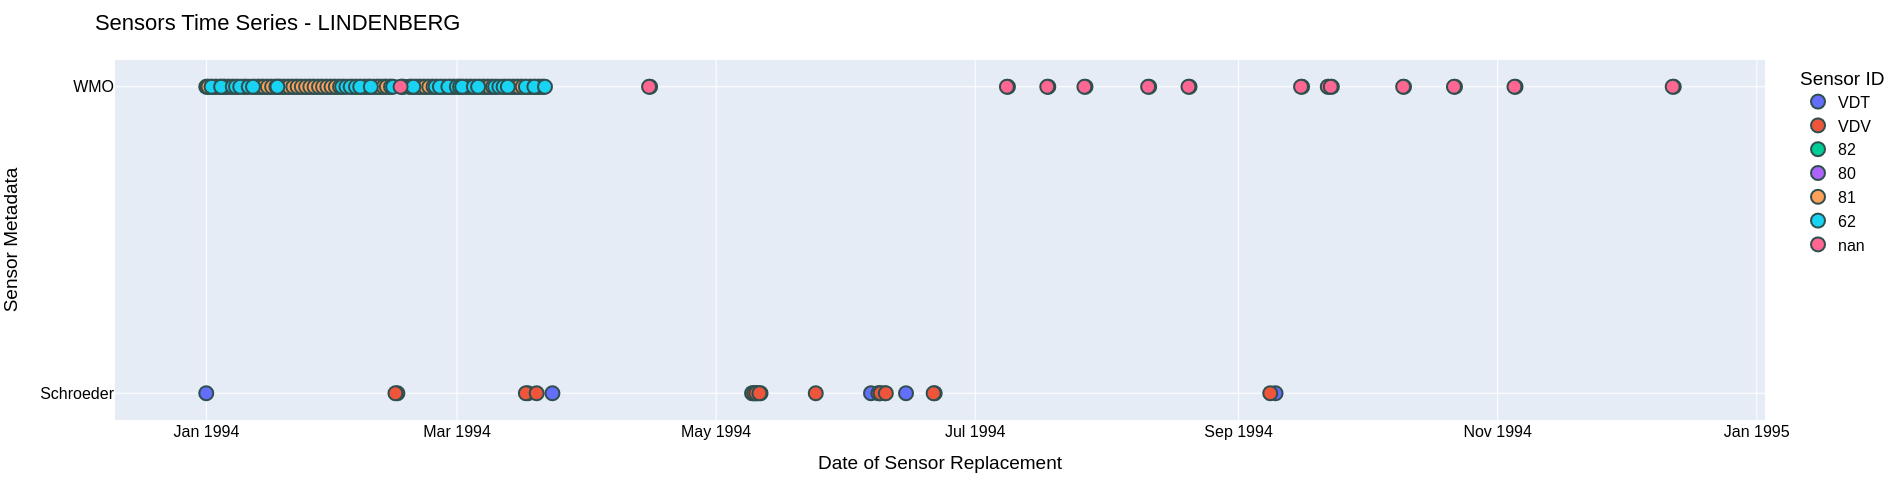

In [360]:
import plotly.express as px


#filter date
data_df = data_df.loc[data_df.date_time <= pd.Timestamp('1995-01-01')]
fig = px.scatter(data_df, x="date_time", y="value", color="sensor_id",
                hover_name="sensor_id", hover_data=["comment"]
                )

fig.update_layout(title='Sensors Time Series - LINDENBERG')
fig.update_yaxes( ticktext= ['Schroeder', 'WMO'],
                  tickvals= [1,2])

fig.update_layout(width= 1700, height = 500)

fig.update_layout(
    xaxis_title="Date of Sensor Replacement",
    yaxis_title="Sensor Metadata",
    legend_title="Sensor ID",
    font=dict(
        size=16,
        color="black"
    )
)

fig.update_traces(marker=dict(size=14,
                              line=dict(width=2,
                                        color='DarkSlateGrey')),
                  selector=dict(mode='markers'))

fig.update_layout(hovermode="x unified")

fig.update_layout(
yaxis = dict(
tickfont = dict(size=16)))


fig.show()

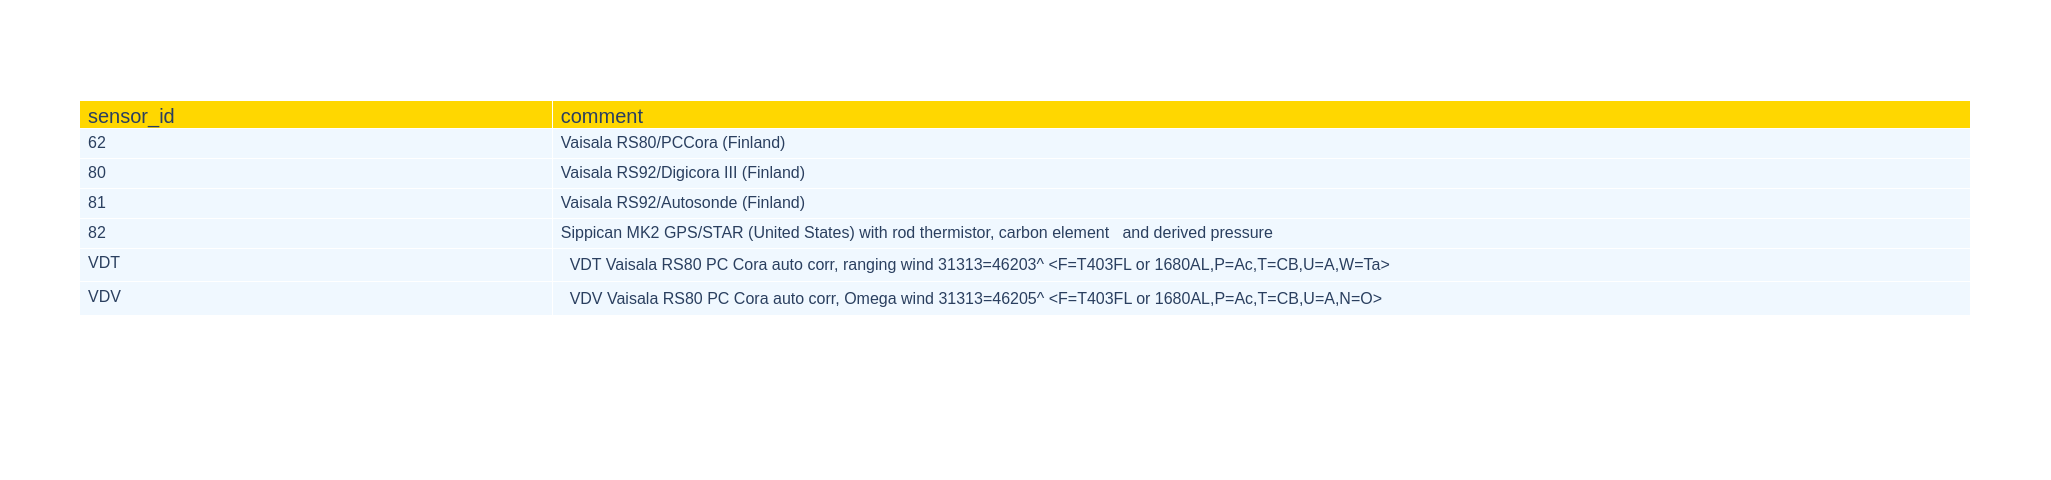

In [389]:
fig = go.Figure(data=[go.Table(
    header=dict(values=list(['sensor_id','comment']),
                fill_color='gold',
                align='left',
                font_size=20),
    columnwidth = [100,300],
    cells=dict(values=[df_sensor.sensor_id, df_sensor.comment],
               fill_color='aliceblue',
               align='left',
               font_size=16,
               height=30
              )),
])

fig.update_layout(width=1900, height=80*len(df_sensor))

fig.show()

# Global Sensor Analysis

In [398]:
def extract_sensors_switch(sensor_conf, file):

    stat = file.split('/')[-1].split('_')[0] 
    #print(stat)
    try:
        f = h5.File(file, 'r')
    except:
        print(file, 'WRONGGGGGG ')
        return False
        
    ts = f['recordtimestamp'][:]

    tsd = pd.to_datetime( ts, unit='s',  origin=pd.Timestamp('1900-01-01') )
    
    # checking indices of dates before and after 2013
    index_minus = np.where(tsd <=  pd.Timestamp('2012-12-01')  )[0]
    index_plus = np.where(tsd >  pd.Timestamp('2013-01-01')  )[0]
        
    if not ( len(index_minus) > 0 and len(index_plus) >0 ):
        return False
    
    else:
        index_minus = index_minus[-1]
        index_plus = index_plus[0]

    index_minus_obs = f['recordindex'][index_minus]
    index_plus_obs = f['recordindex'][index_plus]

    #print(f['observations_table']['sensor_id'][index_minus_obs] ,  f['observations_table']['sensor_id'][index_plus_obs] )
    
    #print('CIAONE', f['observations_table']['sensor_id'][index_plus_obs:])
    #print('ERA5', np.unique(f['era5fb']['sonde_type@conv'][index_plus_obs:]) )
    #valid = [v for v in f['era5fb']['sonde_type@conv'][index_plus_obs:] if not np.isnan(v) ]
    
    #print('VALIDDDD' , type(f['era5fb']['sonde_type@conv'][index_plus_obs]) , len(valid) , len(f['era5fb']['sonde_type@conv'][index_plus_obs:]) )

    #sensor_after =  b''.join(list (f['observations_table']['sensor_id'][index_plus_obs] ) ).decode('utf-8')
    #sensor_after = sensor_after.replace('.0','')
    #print(type(sensor_after))
    #np.isnan(sensor_after)
    
    try:
        sensor_after =  b''.join(list (f['observations_table']['sensor_id'][index_plus_obs] ) ).decode('utf-8')
        sensor_after = sensor_after.replace('.0','')
        #print('OK after ++++ ', sensor_after)
        #print(type(sensor_after) , sensor_after == 'nan')
        if sensor_after == 'nan':
            #print(0)
            
            ### NOTE: here I limit the search up to 50000 obs after 2013-01-01 (one should calculate the number of records though to be more accurate)
            valid = [v for v in f['era5fb']['sonde_type@conv'][index_plus_obs:index_plus_obs+50000] if not np.isnan(v) and v != 'nan' ]
            #print(valid[0] , type(valid[0]))
            sensor_after = str(valid[0]).replace('.0','')
            
            #print(sensor_after , 'CCCC')
    except:
        sensor_after = 'nan' 
        
    
    try:
        #print(index_minus_obs)
        #print(list( f['observations_table']['sensor_id'][index_minus_obs] ) )
        sensor_bef = b''.join( list( f['observations_table']['sensor_id'][index_minus_obs] ) ).decode('utf-8').replace(' ','' )
        #print('OK before', sensor_bef)

    except:
        print('fail sensor before')
        sensor_bef='nan' 

        
    #print(sensor_bef, sensor_after)
    
    # extract the comment for simplicity also 
    try:
        comm_wmo = sensor_conf.loc [sensor_conf['sensor_id_s'] ==  sensor_after ].comments.values[0] 
    except:
        #print(sensor_conf.loc [sensor_conf['sensor_id_s'] ==  sensor_after ])
        comm_wmo = 'NA'
              
    try:
        comm_sch = sensor_conf.loc [sensor_conf['sensor_id_s'] ==  sensor_bef ].comments.values[0]  
    except:
        comm_sch = 'NA'

    #print (sensor_bef,  sensor_after, comm_wmo, min(tsd) , max(tsd), stat  )  
    return (sensor_bef, comm_sch, sensor_after, comm_wmo, min(tsd) , max(tsd), stat  )

#f = extract_sensors_switch(lin)
#sch = [v[0] for v in out ]

In [396]:
files = [merged + '/' + f for f in os.listdir(merged) if '.nc' in f and 'before' not in f and '20300' not in f and '20400' not in f and '20500' not in f  ]

#a = extract_sensors_switch(sensor_conf, files[1000])

#f = h5.File(files[1000])
#for g in  f['observations_table']['sensor_id'][500:].view("|S4"):
#    a = g[0].decode('utf-8')
    #print(g[0].decode('utf-8'))



#files = [f for f in files if '65064' in f ]


In [399]:
POOL = True


if POOL:
    p    = Pool(30)
    func = partial(extract_sensors_switch, sensor_conf )
    out  = p.map(func, files)

else:
    out = []
    for f in files:
        #print(f)
        out.append( extract_sensors_switch(sensor_conf, f) )


#print(out)

fail sensor before
/scratch/das/federico/MERGED_25FEB2022/0-20000-0-59948_CEUAS_merged_v1.nc WRONGGGGGG 
fail sensor before
fail sensor before
fail sensor before
fail sensor before
fail sensor before


In [400]:
# cleaning the results
res = [o for o in out if o]
# creating a dataframe 
all_data = pd.DataFrame({'sch': [v[0] for v in res ], 'sch_comment': [v[1] for v in res ] , 
                        'wmo': [ v[2] for v in res ], 'wmo_comment': [v[3] for v in res ],
                        'min_date': [v[4] for v in res], 'max_date': [ v[5] for v in res],
                        'station': [v[6] for v in res]} )

all_data['min_date'] = all_data['min_date'].dt.date
all_data['max_date'] = all_data['max_date'].dt.date
#all_data['sch_comment'] = [ eval(v).decode('utf-8') if type(v)==bytes else v for v in all_data['sch_comment'] ]


In [ ]:
#all_data

## Complete table with comprising the last sensor metadata from Schroeder and the first sensor metadata from WMO (before/after 2013-01-01) 

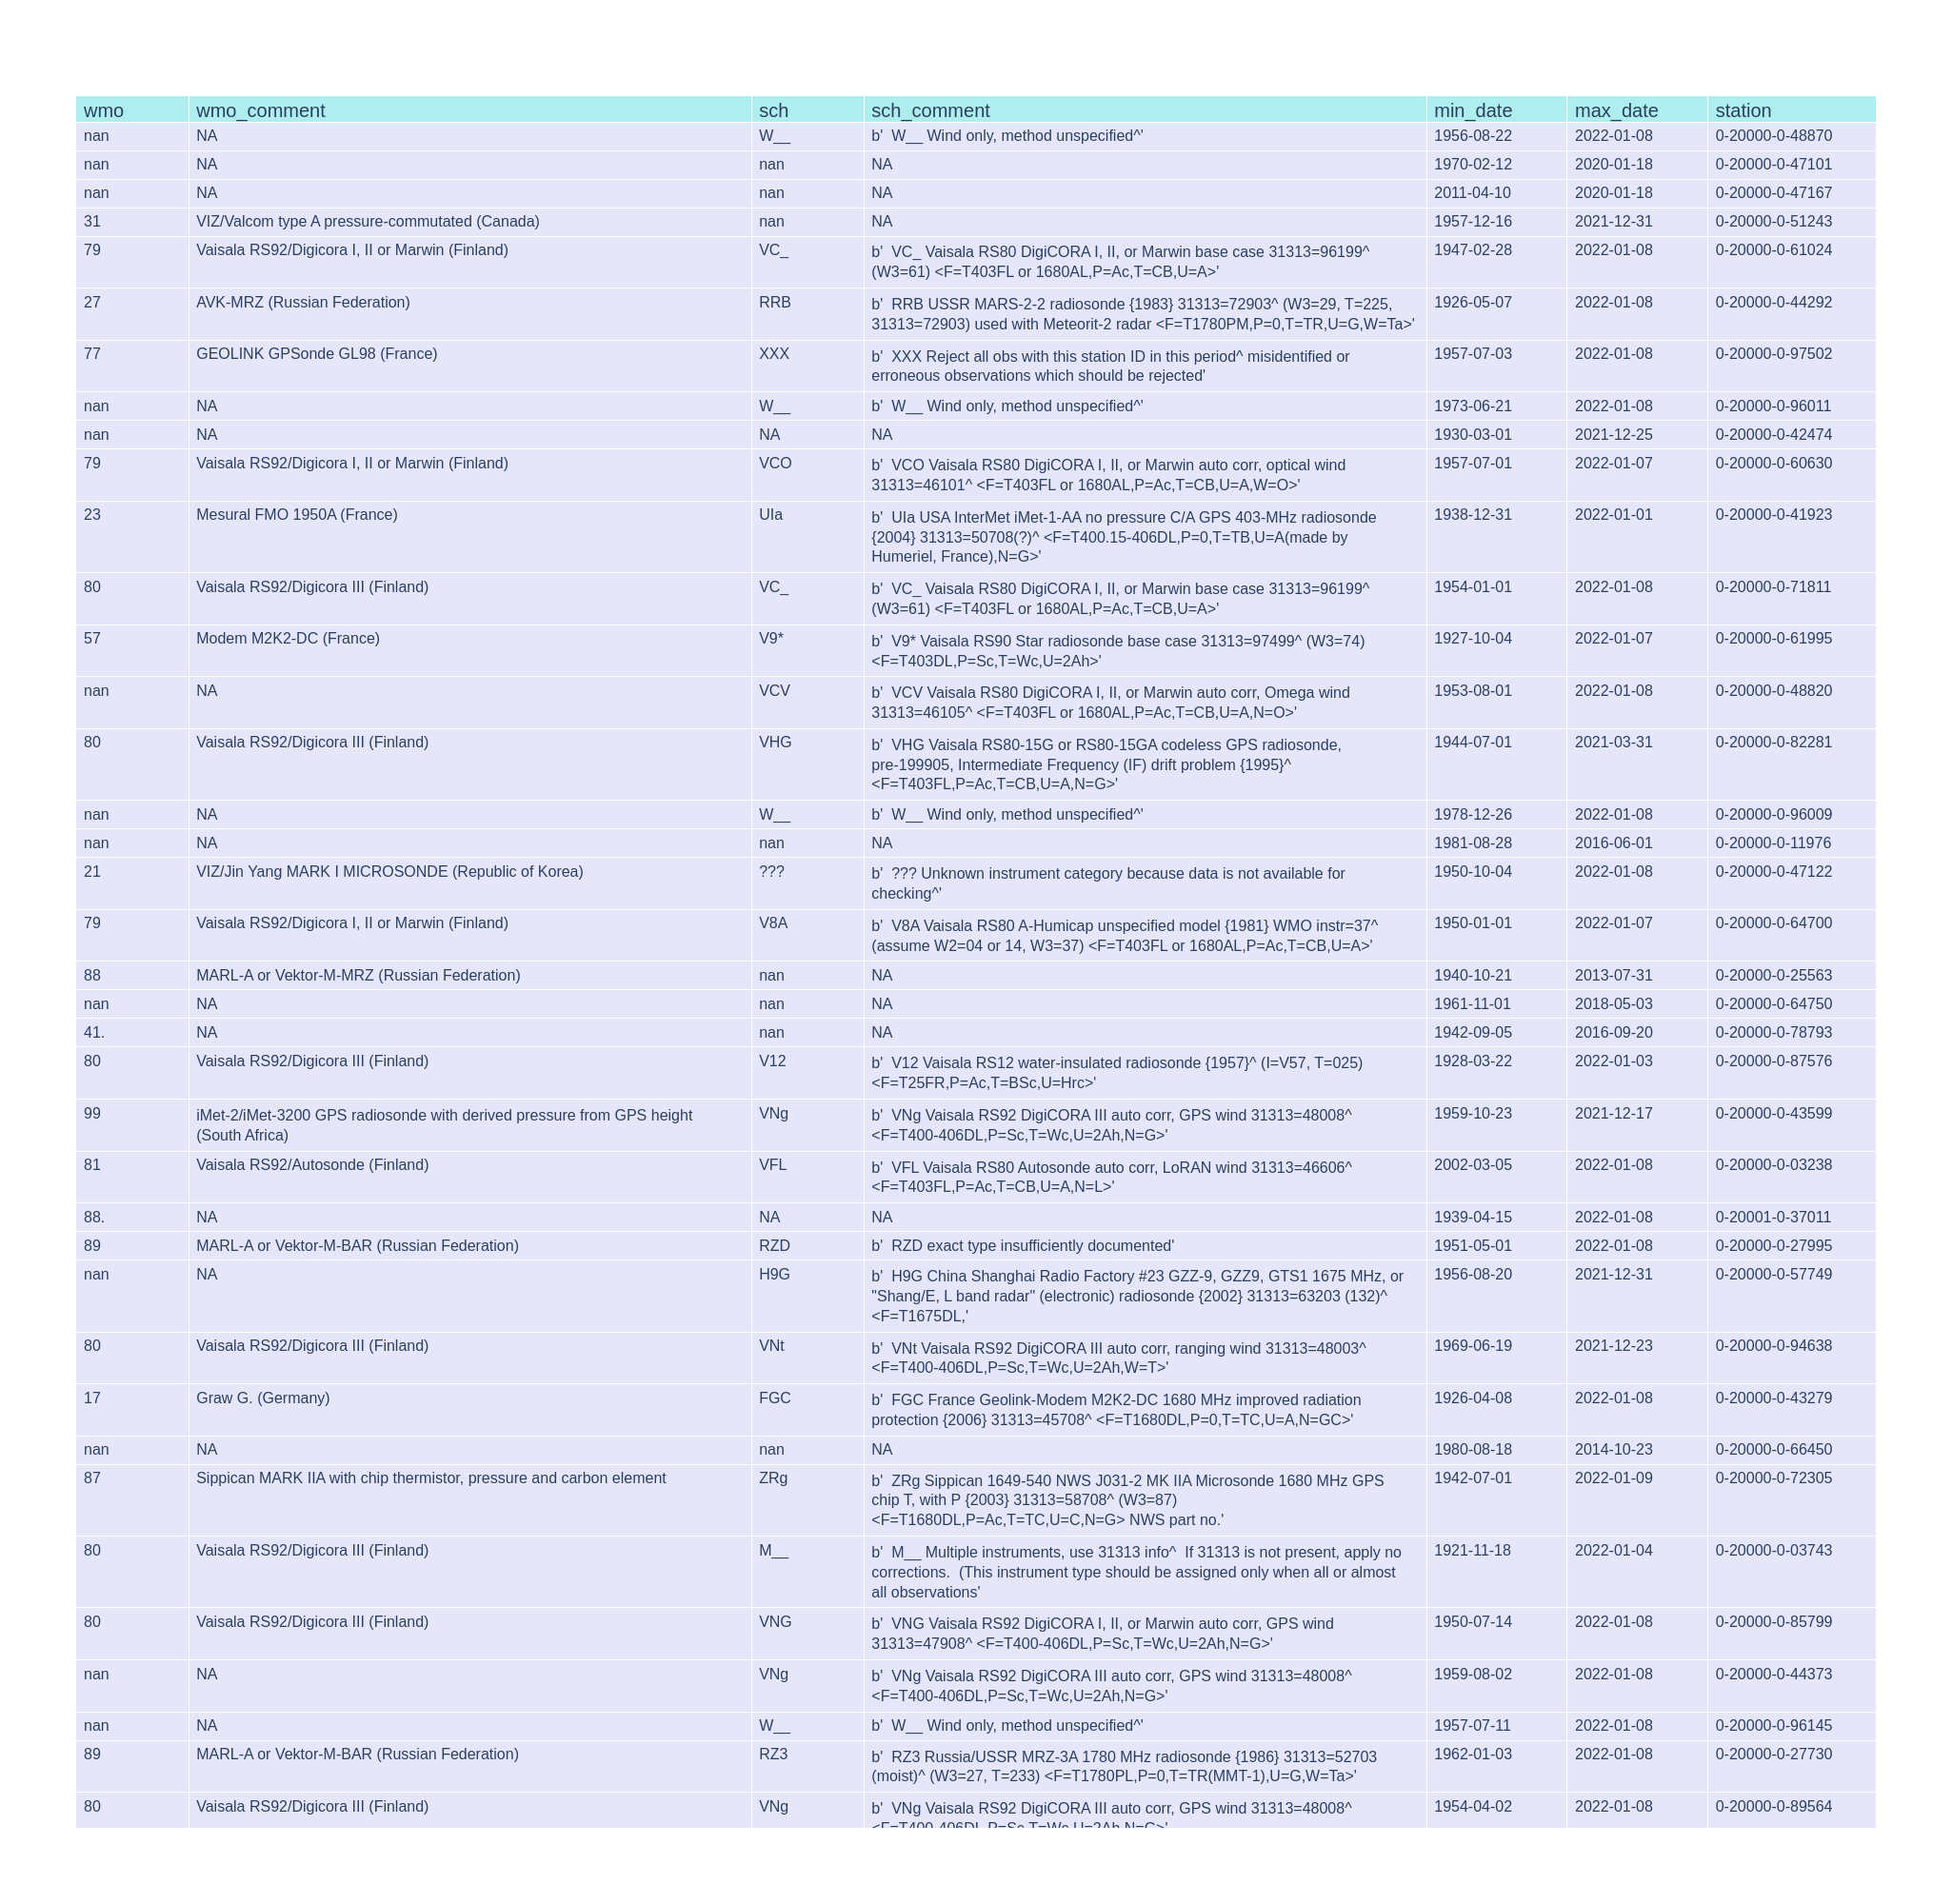

In [401]:
fig = go.Figure(data=[go.Table(
    header=dict(values=list(['wmo','wmo_comment', 'sch' , 'sch_comment' , 'min_date' , 'max_date' , 'station']),
                fill_color='paleturquoise',
                align='left',
               font_size=20),
    columnwidth = [40,200,40,200,50,50,60],
    cells=dict(values=[all_data.wmo, all_data.wmo_comment, all_data.sch, all_data.sch_comment , all_data.min_date , all_data.max_date, all_data.station ],
               fill_color='lavender',
               align='left',
               font_size=16,
               height=30
              )),
])

fig.update_layout(width=1900, height=2000)

fig.show()

## Crate a mapping table of all the sensor ids from Schroder and WMO

In [407]:
sch_ids = [v[0] for v in res ]
wmo_ids = [v[2] for v in res ]


unique_sch , counts_sch = np.unique(sch_ids, return_counts = True )
disc_sch = dict(zip( unique_sch , counts_sch  ))
data_sch = pd.DataFrame( {'sensor_id' : unique_sch , 'counts':counts_sch } )



In [413]:
#all_data
#data_sch

## Plotting distribution of Schroeder's sensors (only for at least 5 counts)

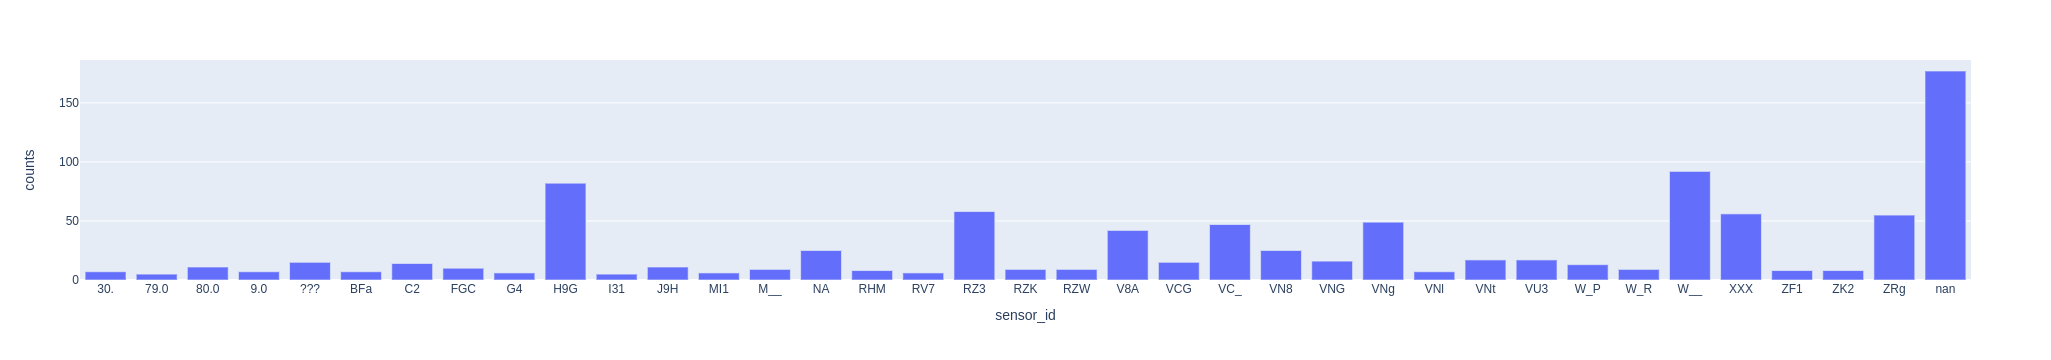

In [412]:

data_sch = data_sch.loc [data_sch.counts >= 5 ]

fig = px.bar(data_sch, x='sensor_id', y='counts')
fig.show()





## Crate a mapping table of all the sensor ids from Schroder and WMO

In [414]:
mapping = {}

for w,s in zip(wmo_ids, sch_ids):
    w = w.replace('.0', '')
    if w not in mapping.keys():
        mapping[w] = []
    if s not in mapping[w]:
        mapping[w].append(s)

In [415]:
dic = {'wmo': [] , 'wmo_comment':[], 'sch':[], 'sch_comment':[]}
for w in mapping.keys():
    #print(w)
    

      
    for s in mapping[w]:
        dic['wmo'].append(w) 
        dic['sch'].append(s)
        
        try:
            dic['wmo_comment'].append(sensor_conf.loc [sensor_conf['sensor_id_s'] ==  w ].comments.values[0] )
        except:
            dic['wmo_comment'].append('NA')
        
        s = s.replace(' ','')
        try:
            #print(sensor_conf.loc [sensor_conf['sensor_id_s'] ==  s ])
            a = sensor_conf.loc [sensor_conf['sensor_id_s'] ==  s ].comments.values[0]  
        except:
            a = 'NA'
        
        dic['sch_comment'].append(a)
    
    
    

In [422]:
df = pd.DataFrame( dic )
df = df.loc[ (df.wmo_comment !='NA') & (df.sch_comment != 'NA') & (df.sch != 'XXX')]
df = df.sort_values(by=['wmo'])

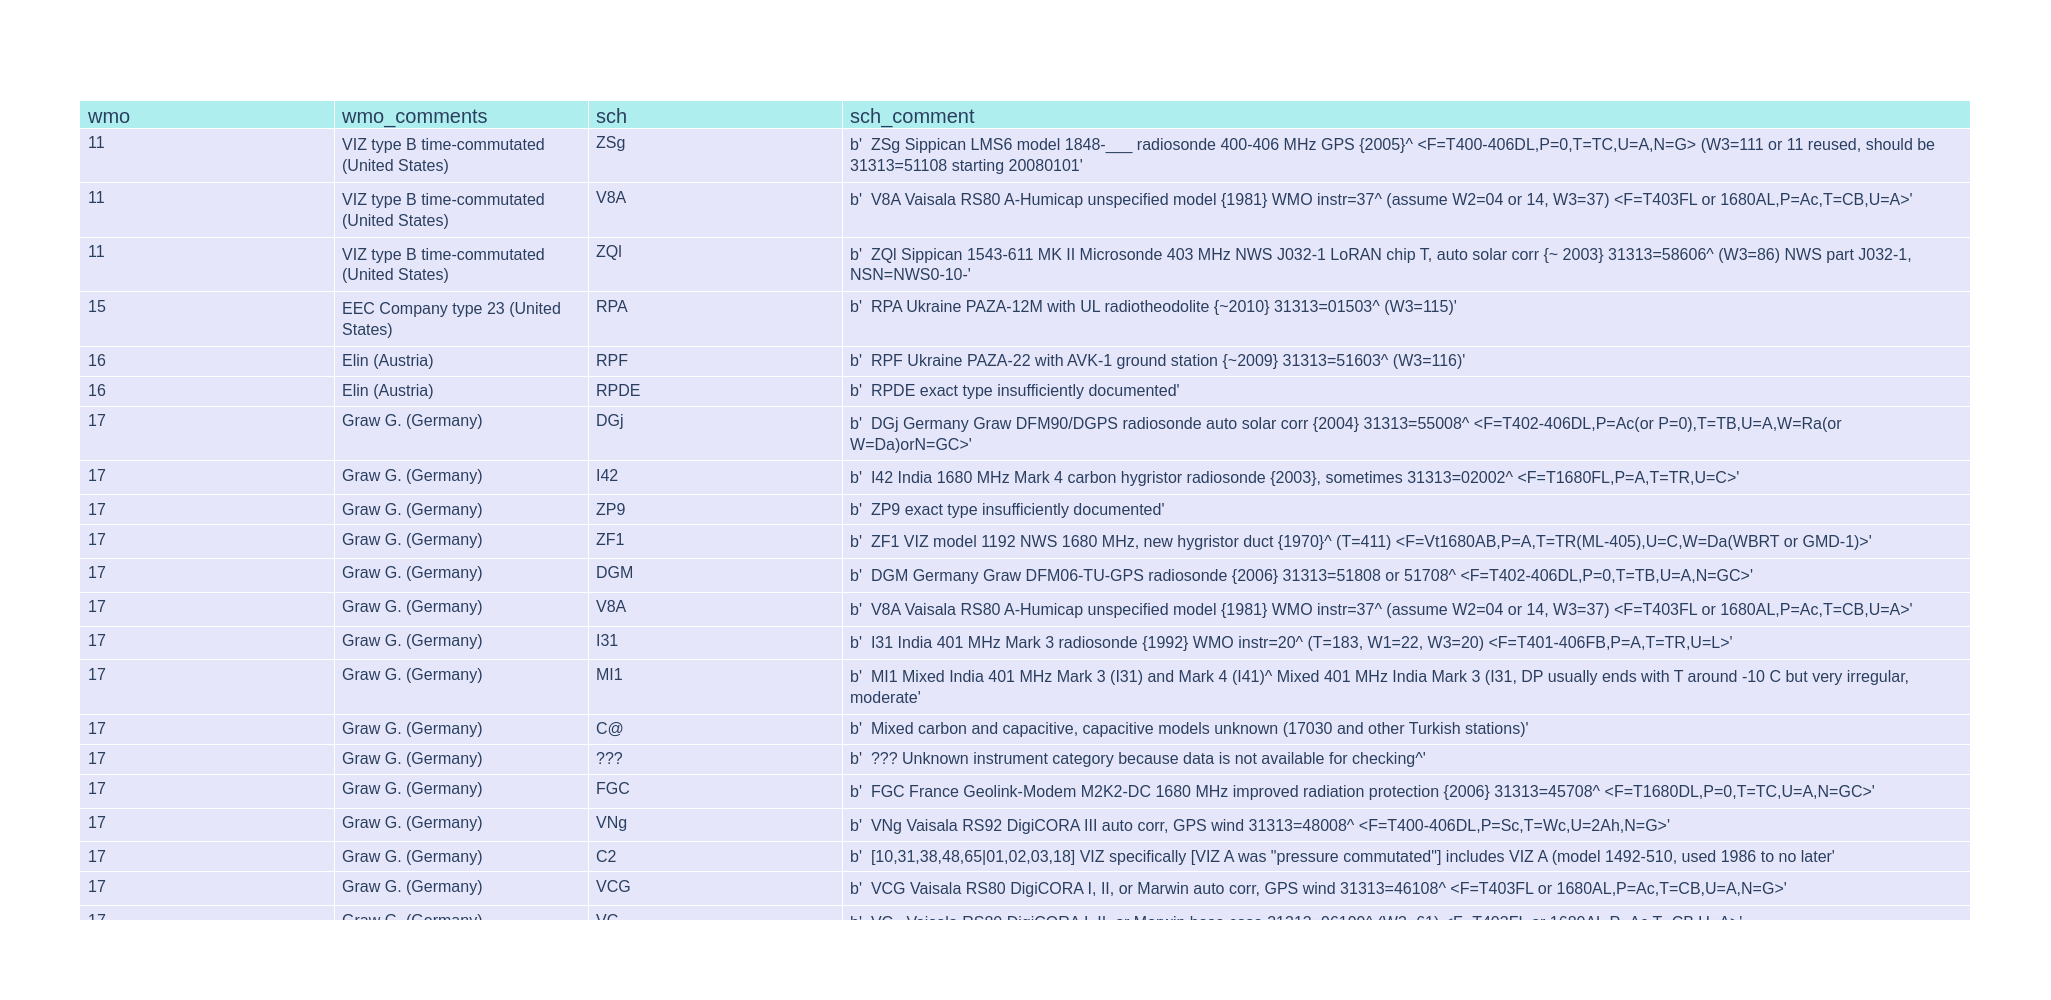

In [423]:
fig = go.Figure(data=[go.Table(
    header=dict(values=list(['wmo','wmo_comments', 'sch' , 'sch_comment']),
                fill_color='paleturquoise',
                align='left',
               font_size=20),
    columnwidth = [90,90,90,400],
    cells=dict(values=[df.wmo, df.wmo_comment, df.sch, df.sch_comment],
               fill_color='lavender',
               align='left',
               font_size=16,
               height=30
              )),
])

fig.update_layout(width=2000, height=1000)

fig.show()